# Aula 38 - árvores, validação e poda


# CART do zero


In [1]:
# === Utilitarios mínimos (acurácia, dataset de exemplo e plot) ===
import numpy as np
import matplotlib.pyplot as plt

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

def make_moons(n=600, noise=0.25, seed=0):
    rng = np.random.RandomState(seed)
    angles = rng.rand(n//2) * np.pi*1.2
    x1 = np.c_[np.cos(angles), np.sin(angles)]
    x2 = np.c_[np.cos(angles), -np.sin(angles)]+[1.0, -0.5]#x1 + [1.0, -0.5]
    X = np.vstack([x1, x2])
    y = np.r_[np.zeros(n//2, dtype=int), np.ones(n//2, dtype=int)]
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

def plot_decision_boundary(model, X, y, h=0.03, proba=False, title="Fronteira de decisão"):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if proba and hasattr(model, "predict_proba"):
        Z = model.predict_proba(grid)
        if Z.ndim == 2 and Z.shape[1] > 1: Z = Z[:,1]
    else:
        Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.7)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k',alpha=0.3)
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()


In [2]:

import numpy as np

def class_probs(y, n_classes=None):
    y = y.astype(int)
    if n_classes is None:
        if y.size == 0:
            return np.array([])
        n_classes = int(np.max(y)) + 1
    counts = np.bincount(y, minlength=n_classes).astype(float)
    s = counts.sum()
    return counts / s if s > 0 else counts

def gini(y):
    p = class_probs(y); return 1.0 - np.sum(p**2)

def entropy(y, eps=1e-12):
    p = class_probs(y); return -np.sum(p * np.log(p + eps))

def impurity(y, criterion="gini"):
    return gini(y) if criterion == "gini" else entropy(y)

def candidate_thresholds(x, max_candidates=50):
    x = np.asarray(x); uniq = np.unique(x)
    if uniq.size < 2: return np.array([])
    if uniq.size > max_candidates:
        qs = np.linspace(0, 1, max_candidates + 2)[1:-1]
        thr = np.unique(np.quantile(x, qs))
    else:
        thr = (uniq[:-1] + uniq[1:]) / 2.0
    return thr

def split_on_threshold(X, y, j, thr):
    xj = X[:, j]
    L = xj <= thr
    R = ~L
    return L, R

def weighted_impurity(yL, yR, criterion="gini"):
    m = yL.size + yR.size
    if m == 0: return 0.0
    return (yL.size * impurity(yL, criterion) + yR.size * impurity(yR, criterion)) / m

def best_split(X, y, *, criterion="gini", max_features=None, rng=None, max_candidates=50, stats=None):

    m, n = X.shape
    parent = impurity(y, criterion)
    if m == 0 or parent <= 0.0:
        return {"gain": 0.0, "feat": None, "thr": None}

    feats = np.arange(n)
    if max_features is not None:
        if isinstance(max_features, str) and max_features == "sqrt":
            k = max(1, int(np.sqrt(n)))
        elif isinstance(max_features, int):
            k = max(1, min(n, max_features))
        else:
            k = n
        if rng is None: rng = np.random.RandomState(0)
        feats = rng.choice(n, size=k, replace=False)

    best = {"gain": 0.0, "feat": None, "thr": None}
    cands = 0; valid = 0
    for j in feats:
        thrs = candidate_thresholds(X[:, j], max_candidates=max_candidates)
        cands += thrs.size
        for t in thrs:
            L, R = split_on_threshold(X, y, j, t)
            if not L.any() or not R.any():
                continue
            valid += 1
            gain = parent - weighted_impurity(y[L], y[R], criterion)
            if gain > best["gain"]:
                best = {"gain": float(gain), "feat": int(j), "thr": float(t)}
    if stats is not None:
        stats['cands'] = stats.get('cands', 0) + int(cands)
        stats['valid'] = stats.get('valid', 0) + int(valid)
    return best

def _leaf(y, n_classes):
    return {"type": "leaf", "proba": class_probs(y, n_classes=n_classes)}

def build_tree(X, y, depth, *, max_depth=8, min_samples_split=2,
               criterion="gini", max_features=None, rng=None, max_candidates=50, stats=None, n_classes=None):
    # Ensurse an effing fixed class dimension for the whole tree
    if n_classes is None:
        n_classes = int(np.max(y)) + 1 if y.size else 0

    if (depth >= max_depth) or (X.shape[0] < min_samples_split) or (impurity(y, criterion) == 0.0):
        return _leaf(y, n_classes)

    split = best_split(X, y, criterion=criterion, max_features=max_features, rng=rng,
                       max_candidates=max_candidates, stats=stats)
    if split["feat"] is None:
        return _leaf(y, n_classes)

    j, t = split["feat"], split["thr"]
    L, R = split_on_threshold(X, y, j, t)
    left = build_tree(X[L], y[L], depth+1, max_depth=max_depth, min_samples_split=min_samples_split,
                      criterion=criterion, max_features=max_features, rng=rng,
                      max_candidates=max_candidates, stats=stats, n_classes=n_classes)
    right = build_tree(X[R], y[R], depth+1, max_depth=max_depth, min_samples_split=min_samples_split,
                       criterion=criterion, max_features=max_features, rng=rng,
                       max_candidates=max_candidates, stats=stats, n_classes=n_classes)
    return {"type": "node", "feat": int(j), "thr": float(t), "left": left, "right": right}

def predict_proba_row(node, x):
    while node["type"] != "leaf":
        node = node["left"] if x[node["feat"]] <= node["thr"] else node["right"]
    return node["proba"]

def predict_proba(tree, X):
    return np.vstack([predict_proba_row(tree, x) for x in X])

def predict(tree, X):
    P = predict_proba(tree, X); return np.argmax(P, axis=1)

class DecisionTree:
    def __init__(self, max_depth=8, min_samples_split=2, criterion="gini",
                 max_features=None, random_state=0, max_candidates=50):
        self.max_depth = max_depth; self.min_samples_split = min_samples_split
        self.criterion = criterion; self.max_features = max_features
        self.random_state = random_state; self.max_candidates = max_candidates
        self.rng_ = np.random.RandomState(random_state); self.tree_ = None
        self.n_classes_ = None
        self.stats_ = {}

    def fit(self, X, y):
        self.n_classes_ = int(np.max(y)) + 1 if y.size else 0
        self.stats_ = {}
        self.tree_ = build_tree(
            X, y, depth=0,
            max_depth=self.max_depth, min_samples_split=self.min_samples_split,
            criterion=self.criterion, max_features=self.max_features, rng=self.rng_,
            max_candidates=self.max_candidates, stats=self.stats_, n_classes=self.n_classes_
        )
        return self

    def predict_proba(self, X): return predict_proba(self.tree_, X)
    def predict(self, X): return np.argmax(self.predict_proba(X), axis=1)

def trace_path(tree, x):
    steps = []; node = tree
    while node["type"] != "leaf":
        j, t = node["feat"], node["thr"]; go_left = x[j] <= t
        steps.append((int(j), float(t), bool(go_left)))
        node = node["left"] if go_left else node["right"]
    return steps, node["proba"]

def pretty_print(node, depth=0):
    import numpy as _np
    indent = "  " * depth
    if node["type"] == "leaf":
        print(f"{indent}Leaf proba={_np.round(node['proba'], 3)}")
    else:
        j, t = node["feat"], node["thr"]
        print(f"{indent}if x[{j}] <= {t:.4f}:")
        pretty_print(node["left"], depth+1)
        print(f"{indent}else:  # x[{j}] > {t:.4f}")
        pretty_print(node["right"], depth+1)


In [3]:

# ===  Passo-a-passo do algoritmo (dataset minúsculo) ===
import numpy as np

X_small = np.array([
    [2.0, 3],
    [2.5, 2],
    [2.7, 5],
    [3.0, 4],
    [3.2, 2],
    [3.6, 6],
], dtype=float)
y_small = np.array([0,0,1,1,0,1], dtype=int)

print("Impureza (Gini) na raiz:", round(impurity(y_small, "gini"), 4))

stats = {}
split = best_split(X_small, y_small, criterion="gini", stats=stats, max_candidates=50)
print("Melhor split:", split)
print("Candidatos avaliados:", stats.get('cands', 0), "| válidos:", stats.get('valid', 0))

tree_small = build_tree(X_small, y_small, depth=0, max_depth=2, criterion="gini", stats={})
pretty_print(tree_small)

steps, proba = trace_path(tree_small, X_small[0])
print("Caminho (feat, thr, vai_esq?):", steps)
print("Probabilidades na folha:", np.round(proba, 3))


Impureza (Gini) na raiz: 0.5
Melhor split: {'gain': 0.5, 'feat': 1, 'thr': 3.5}
Candidatos avaliados: 9 | válidos: 9
if x[1] <= 3.5000:
  Leaf proba=[1. 0.]
else:  # x[1] > 3.5000
  Leaf proba=[0. 1.]
Caminho (feat, thr, vai_esq?): [(1, 3.5, True)]
Probabilidades na folha: [1. 0.]


Acurácia (treino (o todo é treino)): 0.985


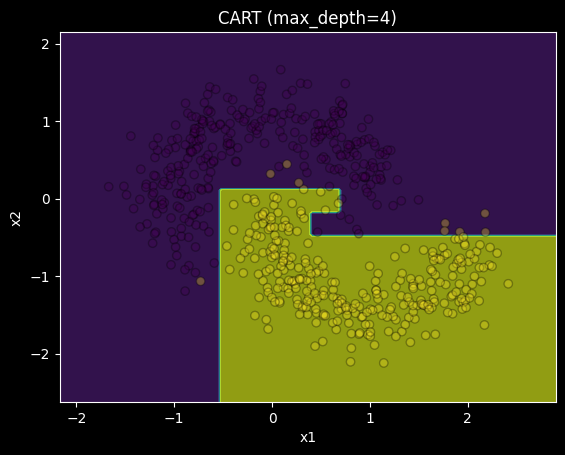

In [4]:

# ===  Demonstração rápida (moons)  ===
X, y = make_moons(n=600, noise=0.25, seed=32)
model = DecisionTree(max_depth=4, criterion="gini", random_state=12).fit(X, y)


print("Acurácia (treino (o todo é treino)):", accuracy(y, model.predict(X)))
#print("Stats (candidatos/validos):", model.stats_)
plot_decision_boundary(model, X, y, title="CART (max_depth=4)")


In [9]:
pretty_print(model.tree_)

if x[1] <= -0.1679:
  if x[0] <= -0.4298:
    if x[0] <= -0.5264:
      if x[1] <= -1.0114:
        Leaf proba=[0.5 0.5]
      else:  # x[1] > -1.0114
        Leaf proba=[1. 0.]
    else:  # x[0] > -0.5264
      Leaf proba=[0. 1.]
  else:  # x[0] > -0.4298
    if x[1] <= -0.4642:
      Leaf proba=[0. 1.]
    else:  # x[1] > -0.4642
      if x[0] <= 0.3965:
        Leaf proba=[0. 1.]
      else:  # x[0] > 0.3965
        Leaf proba=[0.5 0.5]
else:  # x[1] > -0.1679
  if x[1] <= 0.1303:
    if x[0] <= -0.5215:
      Leaf proba=[1. 0.]
    else:  # x[0] > -0.5215
      if x[0] <= 0.6961:
        Leaf proba=[0. 1.]
      else:  # x[0] > 0.6961
        Leaf proba=[1. 0.]
  else:  # x[1] > 0.1303
    if x[1] <= 0.4456:
      if x[1] <= 0.4389:
        Leaf proba=[0.963 0.037]
      else:  # x[1] > 0.4389
        Leaf proba=[0.5 0.5]
    else:  # x[1] > 0.4456
      Leaf proba=[1. 0.]


In [6]:
# @title Rodar aqui para gerar a função plot_custom_decision_tree(tree, y, initial_width=1000, level_height=70, figsize=(20, 6)).
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import itertools

def get_leaf_count(node):
    if node is None:
        return 0
    if node["type"] == "leaf":
        return 1
    return get_leaf_count(node.get("left"),) + get_leaf_count(node.get("right"),)

def calculate_node_positions(node, x_range, y, level_height, positions, leaf_x_coords, depth, node_id_counter, all_y_data):
    if node is None:
        return

    x_min, x_max = x_range
    current_x = (x_min + x_max) / 2

    # Assign a unique ID to the node
    node_id = next(node_id_counter)
    node["plot_id"] = node_id # Store the plot ID in the node itself


    impurity_value = 0.0 # Ignoring it all for now. will fix later. Maybe

    if depth == 0:
        # Ensure all_y_data is a numpy array before calculating root impurity
        if not isinstance(all_y_data, np.ndarray):
            # Fix here later
             print(f"Warning: Expected numpy array for all_y_data at depth 0, but got {type(all_y_data)}. Impurity calculation may be incorrect. (will be fixed at some point)")
             impurity_value = 0.5 # Fallback to a placeholder if data is incorrect
        else:
            # print(f"Calculating root impurity with data of type: {type(all_y_data)}")
            try:
                impurity_value = impurity(all_y_data, criterion="gini")
            except AttributeError as e:
                print(f"Error calculating root impurity: {e}")
                impurity_value = 0.5 # Fallback on error

    # For non-root nodes and leaves, impurity calculation requires data subset
    # Using placeholder values for now, until data subsets are passed down
    elif node["type"] == "leaf":
         # For a leaf, the impurity is ideally 0 if pure, or calculated on leaf data subset
         impurity_value = 0.0 # Placeholder for leaf impurity

    else: # Internal node (depth > 0)
         # Impurity calculation for internal nodes requires data subset
         # Placeholder: Assume some impurity
         impurity_value = 0.3 # Placeholder for internal node impurity


    # Store the calculated position, depth, plot ID, and impurity for the current node
    positions[node_id] = (current_x, y, depth, node_id, impurity_value)


    if node["type"] == "leaf":
        # Assign a unique x-coordinate for each leaf node
        leaf_x_coords.append(current_x)
        return

    next_y = y - level_height
    next_depth = depth + 1

    # Calculate horizontal ranges for children based on the number of leaves in their subtrees
    num_nodes_at_next_level_in_subtree = get_leaf_count(node)

    width_per_pos = (x_max - x_min) / num_nodes_at_next_level_in_subtree if num_nodes_at_next_level_in_subtree > 0 else (x_max - x_min)

    left_child_x_range = (x_min, x_min + width_per_pos * get_leaf_count(node.get("left"),))
    right_child_x_range = (x_max - width_per_pos * get_leaf_count(node.get("right"),), x_max)


    # Think this later

    calculate_node_positions(node.get("left"), left_child_x_range, next_y, level_height, positions, leaf_x_coords, next_depth, node_id_counter, all_y_data) # Passing all_y_data as a placeholder
    calculate_node_positions(node.get("right"), right_child_x_range, next_y, level_height, positions, leaf_x_coords, next_depth, node_id_counter, all_y_data) # Passing all_y_data as a placeholder


def draw_tree_elements(node, ax, positions, level_height):
    """Recursively draws the nodes and connections of the tree."""

    if node is None:
        return

    x, y, depth, plot_id, impurity_value = positions[node["plot_id"]] # Retrieve impurity value



    boxstyle = "round,pad=0.2"
    bbox_props = dict(boxstyle=boxstyle, ec="black", lw=0.5)
    arrow_props = dict(arrowstyle="-", connectionstyle="arc3,rad=0")

    is_leaf = node["type"] == "leaf"

    if is_leaf:
        text = "Leaf"
        bbox_props["fc"] = "lightgreen"
    else:
        text = f"x[{node['feat']}] <= {node['thr']:.4f}" # Display split condition for internal nodes
        bbox_props["fc"] = "lightblue"


    text_color = "black"
    outline_color = "black"

    bbox_props["ec"] = outline_color

    ax.annotate(
        text,
        xy=(x, y),
        xycoords="data",
        textcoords="offset points",
        xytext=(0, 0),
        fontsize=8,
        bbox=bbox_props,
        ha="center",
        va="center",
        zorder=5,
        color=text_color
    )


    if "left" in node and node["left"]:
        child_plot_id = node["left"]["plot_id"]
        if child_plot_id in positions:
            child_x, child_y, child_depth, _, _ = positions[child_plot_id]
            ax.annotate(
                '', xy=(child_x, child_y), xycoords='data',
                xytext=(x, y), textcoords='data', arrowprops=arrow_props,
                zorder=1
            )
            draw_tree_elements(node["left"], ax, positions, level_height)


    if "right" in node and node["right"]:
        child_plot_id = node["right"]["plot_id"]
        if child_plot_id in positions:
            child_x, child_y, child_depth, _, _ = positions[child_plot_id]
            ax.annotate(
                '', xy=(child_x, child_y), xycoords='data',
                xytext=(x, y), textcoords='data', arrowprops=arrow_props,
                zorder=1
            )
            draw_tree_elements(node["right"], ax, positions, level_height)


def plot_custom_decision_tree(tree, all_y_data, initial_width=1000, level_height=80, figsize=(12, 8)):
    """
    Plots a custom decision tree structure.

    Args:
        tree (dict): The dictionary representing the custom decision tree.
        all_y_data (np.ndarray): The full target variable data used to train the tree (for root impurity).
                                 Note: Impurity for later. don't forget
        initial_width (int, optional): The initial horizontal width allocated for the tree.
                                       Defaults to 1000. If needed, fix figsize to show all nodes.
        level_height (int, optional): The vertical spacing between tree levels. Defaults to 80.
        figsize (tuple, optional): The size of the matplotlib figure. Defaults to (12, 8).
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_axis_off()


    node_id_counter = itertools.count()


    positions = {}
    leaf_x_coords = []

    calculate_node_positions(tree, x_range=(-initial_width/2, initial_width/2), y=0, level_height=level_height, positions=positions, leaf_x_coords=leaf_x_coords, depth=0, node_id_counter=node_id_counter, all_y_data=all_y_data)


    if leaf_x_coords:
        min_leaf_x = min(leaf_x_coords)
        max_leaf_x = max(leaf_x_coords)
        center_offset = -(min_leaf_x + max_leaf_x) / 2

        plot_width = initial_width
        calculated_width = max_leaf_x - min_leaf_x
        scale_factor = (plot_width - 2*50) / calculated_width if calculated_width > 0 else 1.0

        for plot_id in positions: # Iterate through plot_ids in positions
            x, y, depth, current_plot_id, impurity_value = positions[plot_id]

            adjusted_x = (x + center_offset) * scale_factor
            positions[plot_id] = (adjusted_x, y, depth, current_plot_id, impurity_value) #



    draw_tree_elements(tree, ax, positions, level_height)

    all_x = [pos[0] for pos in positions.values()]
    all_y = [pos[1] for pos in positions.values()]

    if all_x and all_y:
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)


        padding = 50
        ax.set_xlim(min_x - padding, max_x + padding)
        ax.set_ylim(min_y - padding, max_y + padding)


    plt.show()

# plot_custom_decision_tree(model.tree_, y, initial_width=500, level_height=70, figsize=(20, 6))

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


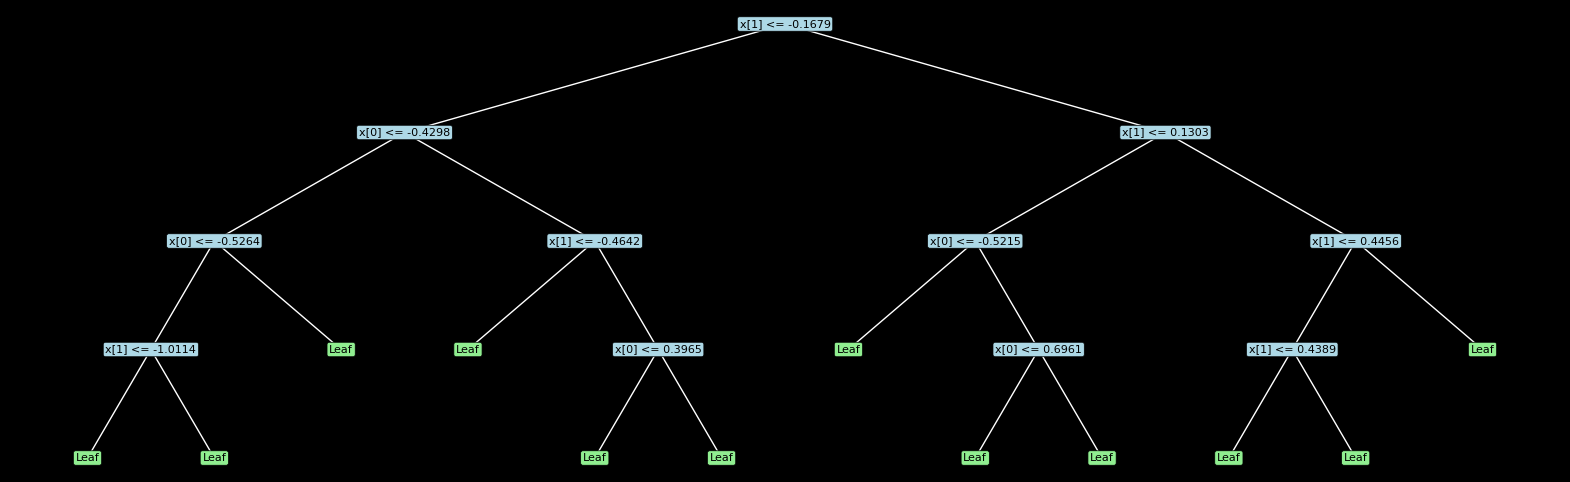

In [ ]:
plot_custom_decision_tree(model.tree_, y, initial_width=1000, level_height=70, figsize=(20, 6))
